# Time series - multivariate prediction, LSTM network for fixed-sized prediction

In this example we will load prepared data and try to predict it with a simple lstm network producing fixed-sized prediction.

This example is very similar to the feed-forward network except the model is smaller and it can predict from history of arbitrary length.

In [1]:
%tensorflow_version 2.x
%matplotlib inline

import numpy as np
import os
from datetime import date
import re

import matplotlib.pyplot as plt

import pandas as pd
pd.options.display.max_rows = 30
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

TensorFlow 2.x selected.


In [13]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
PATH = '/content/drive/My Drive/ml-college/time-series-analysis/data/weather/ts_temp_dp_press.p'
training_df = pd.read_pickle(PATH)

Notice that we would randomly sample the training data from the whole weather history.

The `indices` array will contain starting date for each sample

In [0]:
import random

HISTORY_LEN = 14
PREDICTION_LEN = 7
NUM_SAMPLES = 2000
NUM_INPUTS = len(training_df.columns)

indices = random.sample(range(0,len(training_df) - HISTORY_LEN - PREDICTION_LEN), NUM_SAMPLES)

In this example only the output needs to be reshaped into one-dimensional shape. Inputs need to be in a sequence form

In [0]:
ts_data = training_df.values
ts_inputs = np.array([ts_data[i:i + HISTORY_LEN] for i in indices])
ts_outputs = np.array([ts_data[i + HISTORY_LEN: i + HISTORY_LEN + PREDICTION_LEN] for i in indices]).reshape((NUM_SAMPLES, PREDICTION_LEN * NUM_INPUTS))

In [8]:
from tensorflow.keras import Model
from tensorflow.keras.layers import LSTM, GRU, Input, Dense

inputs = Input(shape=ts_inputs.shape[1:])
x = GRU(32, return_sequences=True, recurrent_activation='sigmoid')(inputs)
x = GRU(16, recurrent_activation='sigmoid')(x)
outputs = Dense(PREDICTION_LEN * NUM_INPUTS, activation='linear')(x)

model = Model(inputs, outputs)
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 14, 4)]           0         
_________________________________________________________________
gru (GRU)                    (None, 14, 32)            3648      
_________________________________________________________________
gru_1 (GRU)                  (None, 16)                2400      
_________________________________________________________________
dense (Dense)                (None, 28)                476       
Total params: 6,524
Trainable params: 6,524
Non-trainable params: 0
_________________________________________________________________


In [9]:
model.fit(ts_inputs, ts_outputs, validation_split=0.1, epochs=100)

Train on 1800 samples, validate on 200 samples
Epoch 1/100
1800/1800 [==============================] - 8s 4ms/sample - loss: 0.2245 - val_loss: 0.0875
Epoch 2/100
1800/1800 [==============================] - 1s 302us/sample - loss: 0.0779 - val_loss: 0.0769
Epoch 3/100
1800/1800 [==============================] - 1s 311us/sample - loss: 0.0750 - val_loss: 0.0754
Epoch 4/100
1800/1800 [==============================] - 1s 299us/sample - loss: 0.0739 - val_loss: 0.0743
Epoch 5/100
1800/1800 [==============================] - 1s 318us/sample - loss: 0.0728 - val_loss: 0.0733
Epoch 6/100
1800/1800 [==============================] - 1s 319us/sample - loss: 0.0715 - val_loss: 0.0713
Epoch 7/100
1800/1800 [==============================] - 1s 324us/sample - loss: 0.0694 - val_loss: 0.0689
Epoch 8/100
1800/1800 [==============================] - 1s 321us/sample - loss: 0.0675 - val_loss: 0.0672
Epoch 9/100
1800/1800 [==============================] - 1s 304us/sample - loss: 0.0664 - val_loss:

## Prediction phase

To test the prediction, we will take a particular date and feed the history into the network.

Notice the `DatetimeIndex` usage that allows us to easily align our prediction to the input time series.

In [0]:
import datetime
from datetime import timedelta

In [0]:
prediction_date = date(2012, 12, 25)

prediction_input = training_df[prediction_date - timedelta(days=HISTORY_LEN - 1): prediction_date]
prediction = model.predict(prediction_input.values.reshape(1, HISTORY_LEN, NUM_INPUTS))

history = training_df[prediction_date - timedelta(days=HISTORY_LEN - 1): prediction_date + timedelta(days=PREDICTION_LEN)]
prediction_df = pd.DataFrame(prediction.reshape((PREDICTION_LEN, NUM_INPUTS)), index=pd.date_range(start=prediction_date + timedelta(days=1), freq='D', periods=PREDICTION_LEN))

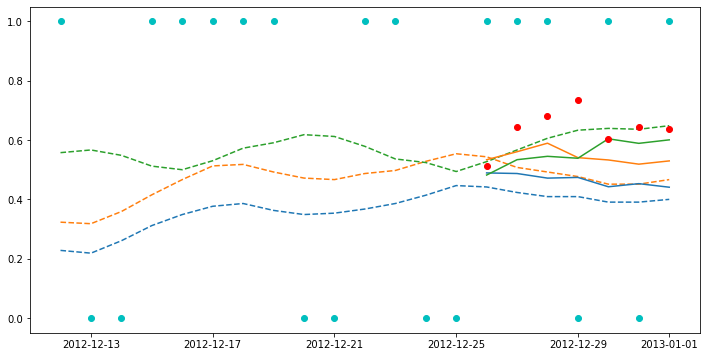

In [12]:
plt.figure(figsize = (12, 6))
history_plt = plt.plot(history.iloc[:,0:3], linestyle='--')
plt.plot(history.iloc[:,3], 'oc')
plt.plot(prediction_df.iloc[:,0], color=history_plt[0].get_color())
plt.plot(prediction_df.iloc[:,1], color=history_plt[1].get_color())
plt.plot(prediction_df.iloc[:,2], color=history_plt[2].get_color())
plt.plot(prediction_df.iloc[:,3], 'or')
plt.show()